# Import libraries

In [ ]:
# Fix randomness and hide warnings
seed = 444

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.17.0


In [ ]:
# Import some other useful libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

ONLY FOR GOOGLE COLAB

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# with open('/content/drive/MyDrive/public_data.npz', 'r') as f:
#   file_content = f.read()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preprocessing

In [ ]:
# Import data

data = np.load('/content/drive/MyDrive/ANNDL: Challenge 1/public_data.npz',allow_pickle=True)
lst = data.files
images = data[lst[0]]
labels = data[lst[1]]

# Convert values in data to int
images = images.astype(int)

print(images.shape)

(5200, 96, 96, 3)


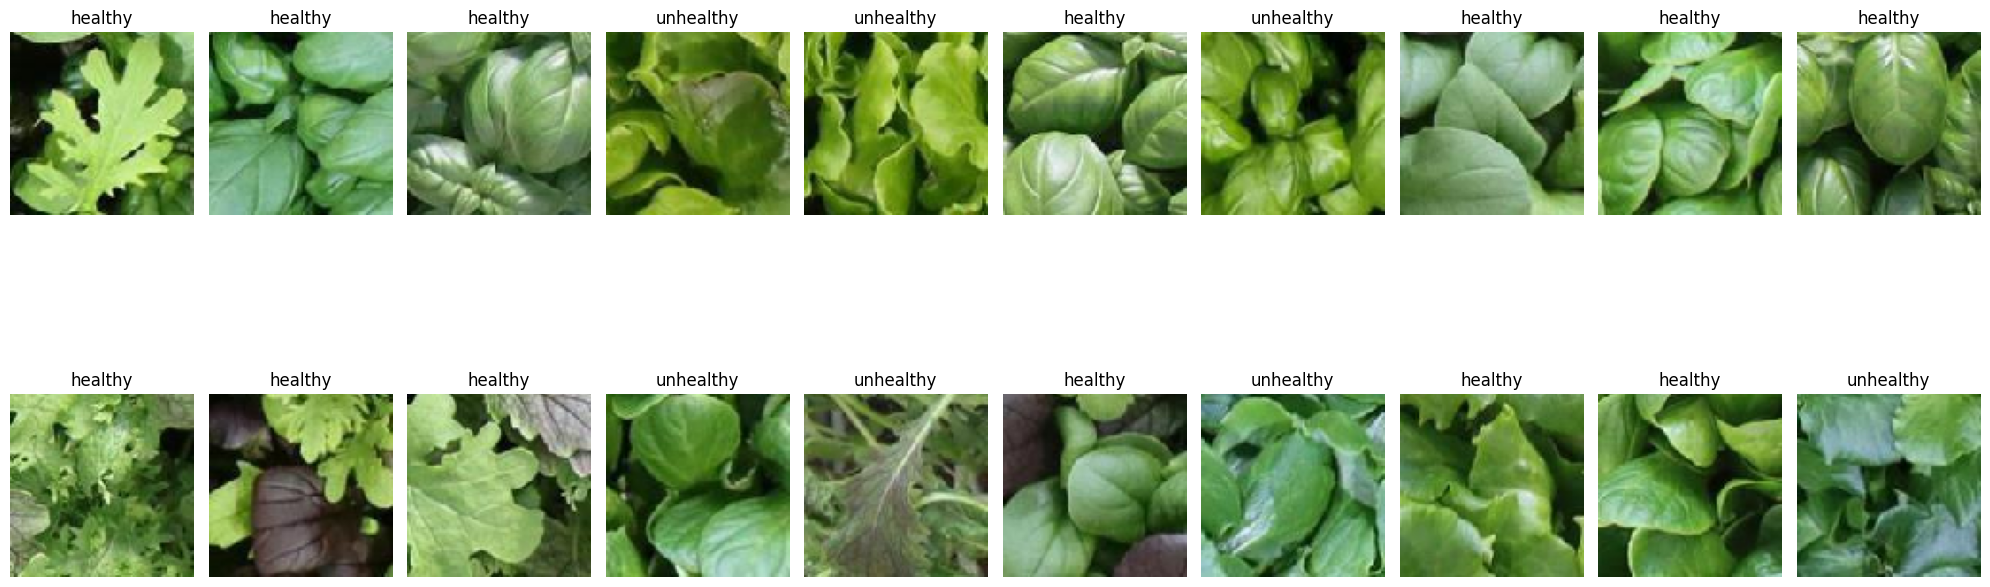

In [ ]:
# Visualisation of first 20 images
fig , axes = plt.subplots(2,10, figsize = (20,9))
axes = axes.reshape((-1,))
for i in range(20):
    axes[i].imshow(np.clip(images[i],0,255))
    axes[i].axis('off')
    axes[i].set_title(labels[i])

plt.tight_layout()
plt.savefig('boh.png')

## Dimensionality reduction for anomaly detection

### PCA

Percentage of variance explained by the principal components: [0.10320786 0.06540438]


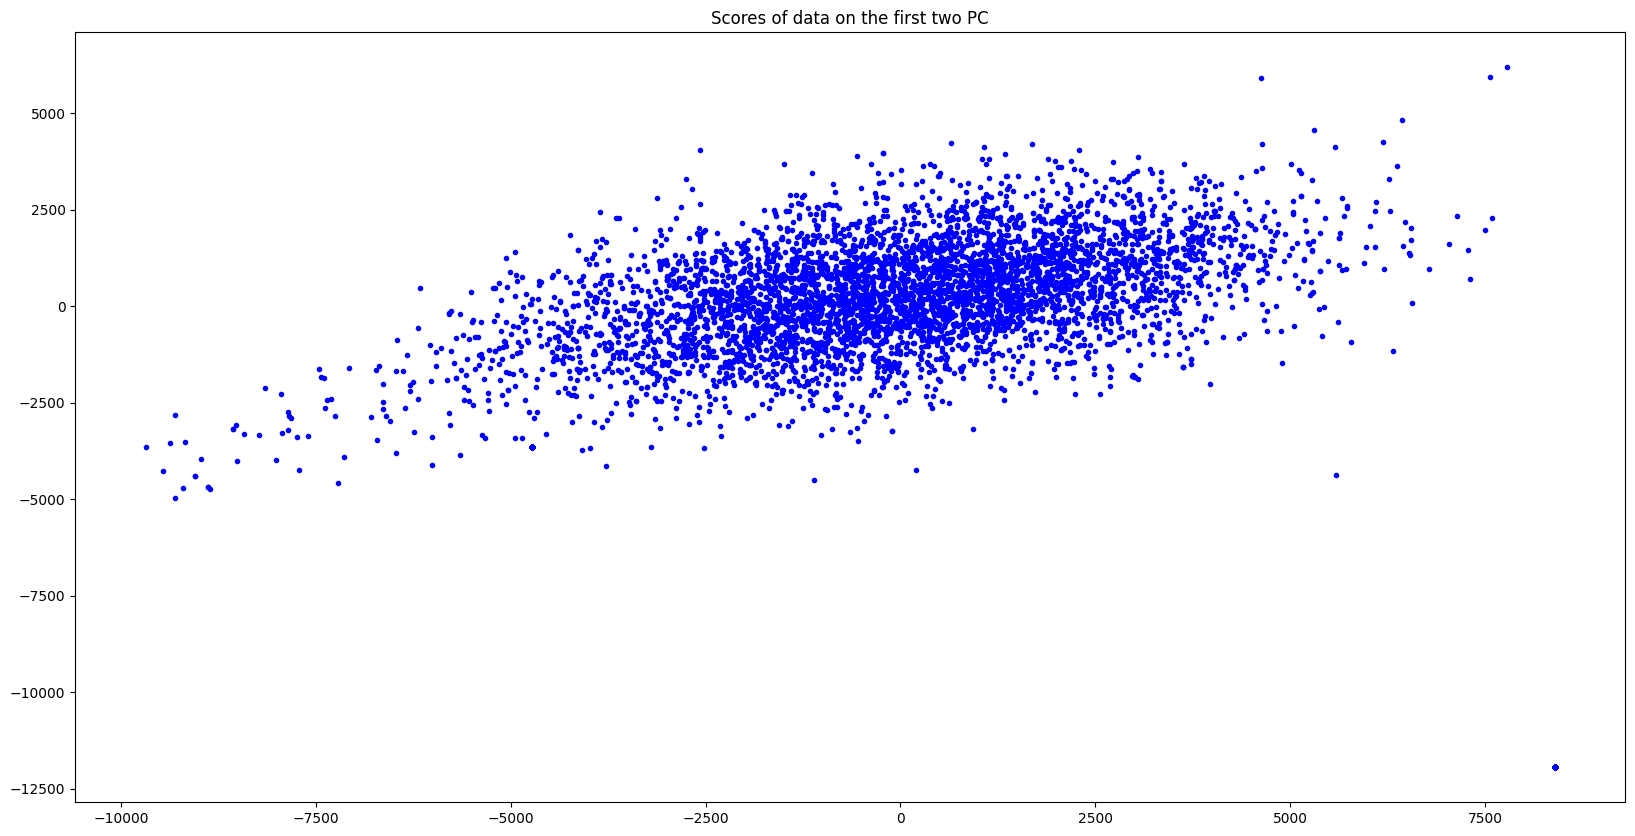

In [ ]:
# Dimensional reduction with PCA for anomaly detection

#img = images[0].reshape((1,3*96*96))
images_flat = images.reshape((5200,3*96*96))
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(images_flat)
print("Percentage of variance explained by the principal components:",pca.explained_variance_ratio_)
scores = pca.transform(images_flat)
#scores.shape

plt.figure(figsize=[20,10])
plt.title('Scores of data on the first two PC')
plt.plot(scores[:,0],scores[:,1], 'b.')
plt.show()


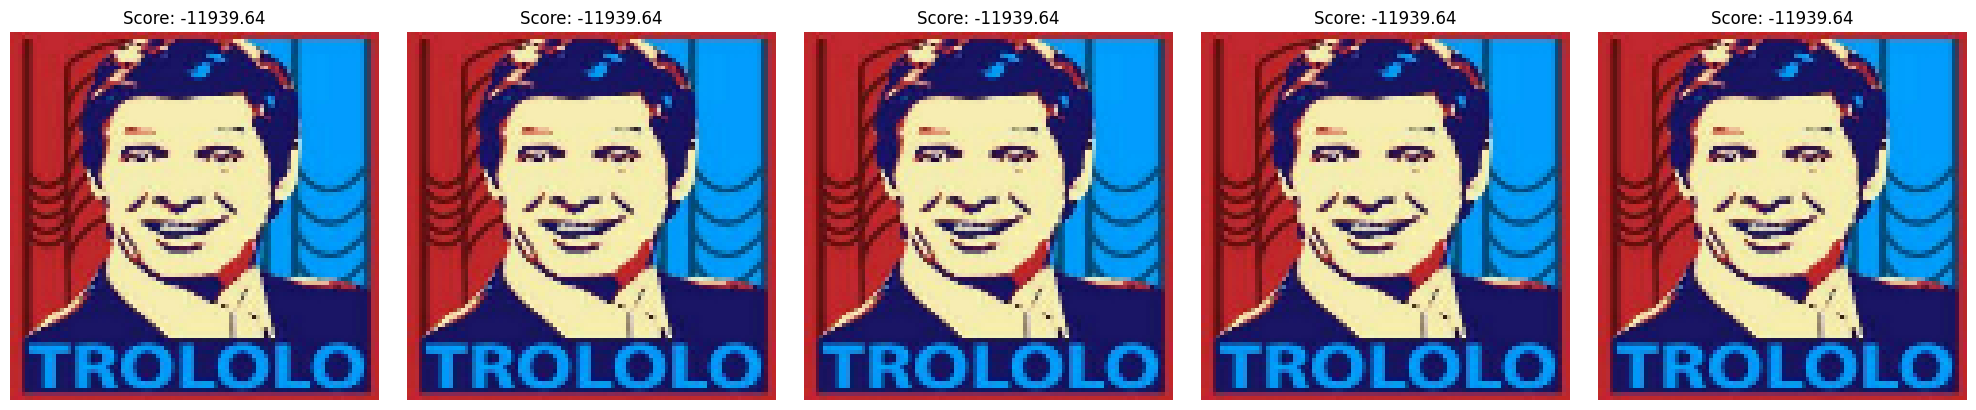

In [ ]:
# prompt: show the 5 lowest score images in y score

import matplotlib.pyplot as plt
import numpy as np
y_score = scores[:, 1]  # Assuming you want to use the first principal component for anomaly score

# Find indices of the 5 lowest scores
lowest_score_indices = np.argsort(y_score)[:5]

# Plot the 5 images with the lowest scores
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, idx in enumerate(lowest_score_indices):
    axes[i].imshow(np.clip(images[idx], 0, 255))
    axes[i].axis('off')
    axes[i].set_title(f"Score: {y_score[idx]:.2f}")

plt.tight_layout()
plt.show()


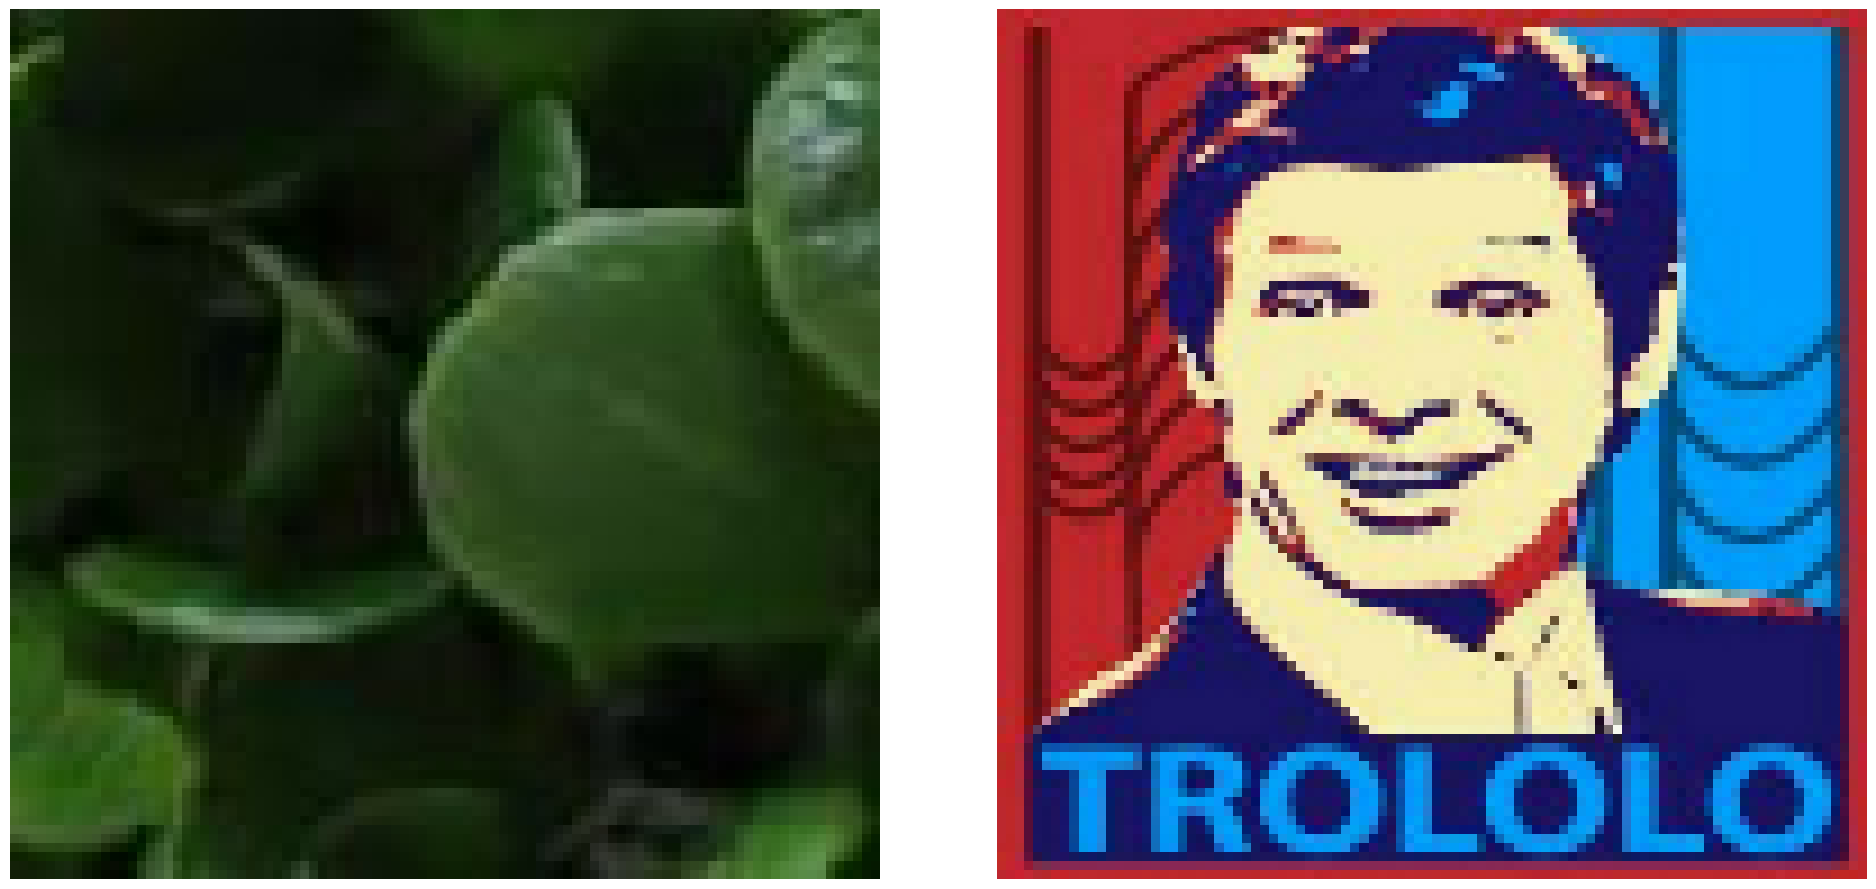

In [ ]:
# Check outliers

from scipy.spatial import distance

# Compute the mahalanobis distance for scores of the two first PCs to find possible outliers
mahalanobis_distances = [distance.mahalanobis(x, np.mean(scores,axis=0), np.linalg.inv(np.cov(scores.T))) for x in scores]
out = np.where(np.array(mahalanobis_distances) >=4)[0]

uniq = np.unique(images[out],axis=0)

#Plot the outliers
fig , axes = plt.subplots(1,len(uniq), figsize = (20,9))
axes = axes.reshape((-1,))
for i in range(len(uniq)):
    axes[i].imshow(np.clip(uniq[i],0,255))
    axes[i].axis('off')
    #axes[i].set_title(un)

plt.tight_layout()

First outlier found (trololo image). Absolutly misleading for the task.
The other oulier found is actualy an image of a leaf, so it has to be included in the dataset.
Trying to use another algorithm to spot other outliers.

### t-SNE

#### function declaration

In [ ]:
from matplotlib.gridspec import GridSpec
from sklearn.manifold import TSNE
import hashlib

# Function to hash images for detecting duplicates
def hash_image(image):
    return hashlib.md5(image.tobytes()).hexdigest()

def tsne_outlier_detection(images_flat):

    scores_tsne = TSNE(n_components=2,perplexity=60).fit_transform(images_flat)

    # Find outliers
    mahalanobis_distances = [distance.mahalanobis(x, np.mean(scores_tsne,axis=0), np.linalg.inv(np.cov(scores_tsne.T))) for x in scores_tsne]
    out = np.where(np.array(mahalanobis_distances) >= 2.5)[0]

    # Visualize outliers
    uniq = np.unique(images[out],axis=0)


    # Find indices of the images with the largest Mahalanobis distances
    highest_distance_indices = np.argsort(mahalanobis_distances)[::-1]

    # Filter out duplicates based on image hashes
    unique_images = []
    unique_indices = []
    for idx in highest_distance_indices:
        img_hash = hash_image(images[idx])
        if img_hash not in unique_images:
            unique_images.append(img_hash)
            unique_indices.append(idx)
        if len(unique_indices) >= 6:  # Limit to 6 unique images
            break

    # Create a figure for the plot and images
    fig = plt.figure(figsize=(15, 10))
    gs = GridSpec(3, 4, figure=fig)  # Create a grid spec with 3 rows, 4 columns

    # Define a colormap for differentiating image points on the t-SNE plot
    colors = ['r', 'g', 'b', 'c', 'm', 'y']

    # Plot the t-SNE visualization (spanning the entire left side, i.e., first 3 rows of the first column)
    ax_tsne = fig.add_subplot(gs[:, :2])  # Large t-SNE plot (3 rows, 2 columns)
    ax_tsne.scatter(scores_tsne[:, 0], scores_tsne[:, 1], s=10, c='gray', label="Other points")
    ax_tsne.set_title('t-SNE Visualization')

    # Plot the 6 unique images with the highest Mahalanobis distances on the right (spanning 3 rows, 2 columns)
    for i, idx in enumerate(unique_indices):
        ax_img = fig.add_subplot(gs[i // 2, 2 + i % 2])  # Create the subplots for images on the right side
        ax_img.imshow(np.clip(images[idx], 0, 255))
        ax_img.axis('off')
        ax_img.set_title(f"Index: {idx}\nDistance: {mahalanobis_distances[idx]:.2f}")

        # Highlight the corresponding point on the t-SNE plot with different colors
        ax_tsne.scatter(scores_tsne[idx, 0], scores_tsne[idx, 1], s=50, c=colors[i], marker='o', label=f"Image {i+1}")

    # Add a legend to the t-SNE plot for the highlighted images
    ax_tsne.legend()

    plt.tight_layout()
    plt.show()

### Checking the dataset

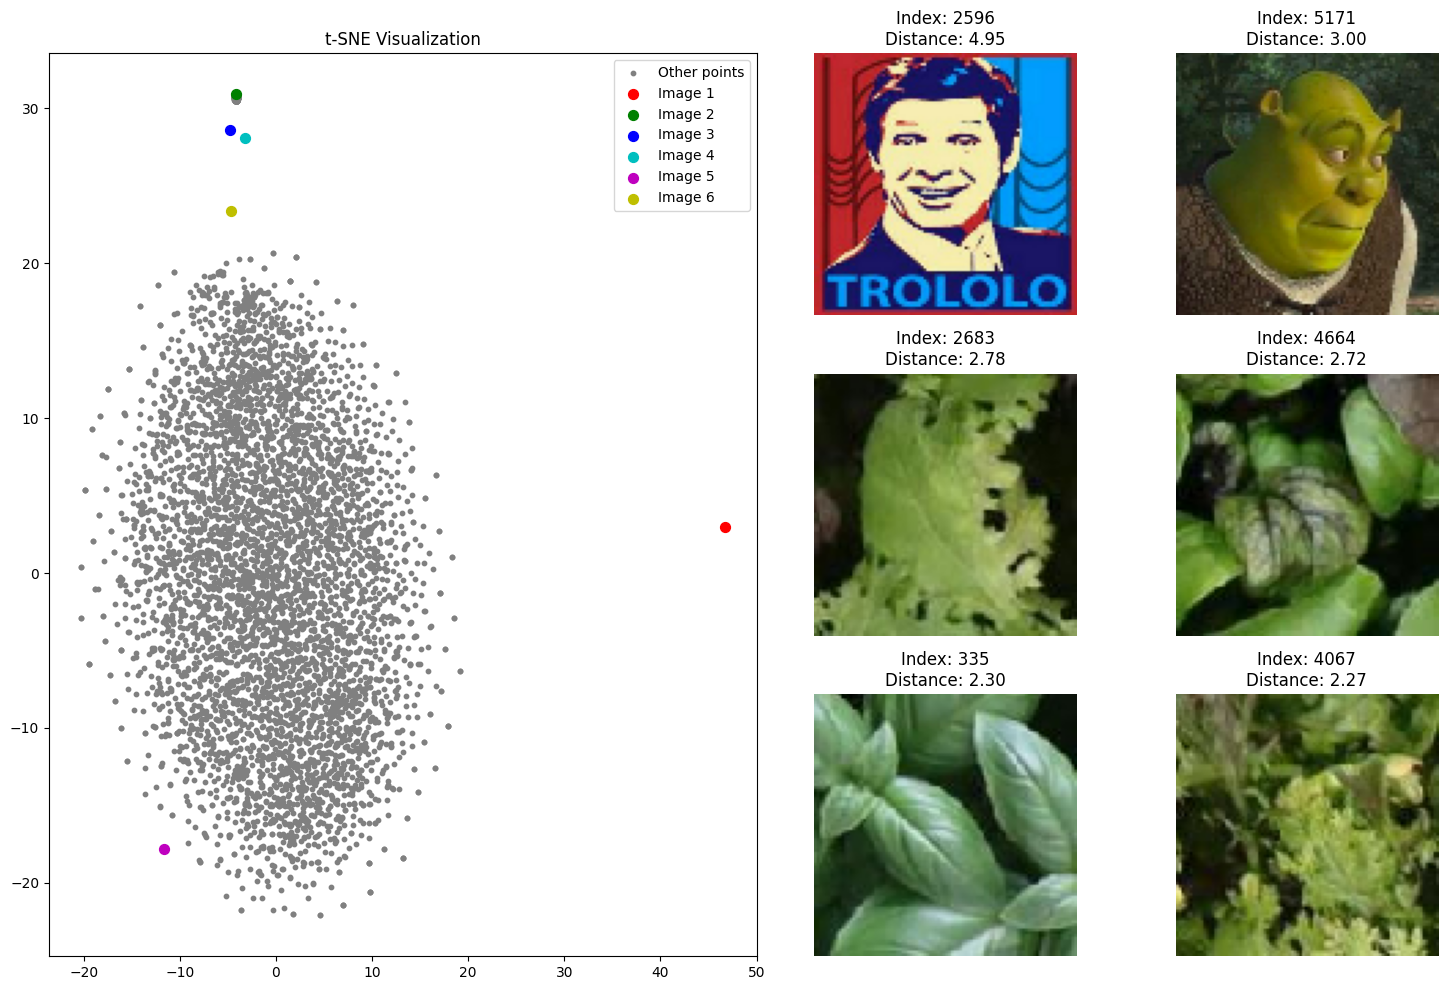

In [ ]:
tsne_outlier_detection(images_flat)

With t-SNE, found another group of outliers (shrek images). Found trololo image as before. The others are leaves images, so they have to be considered.

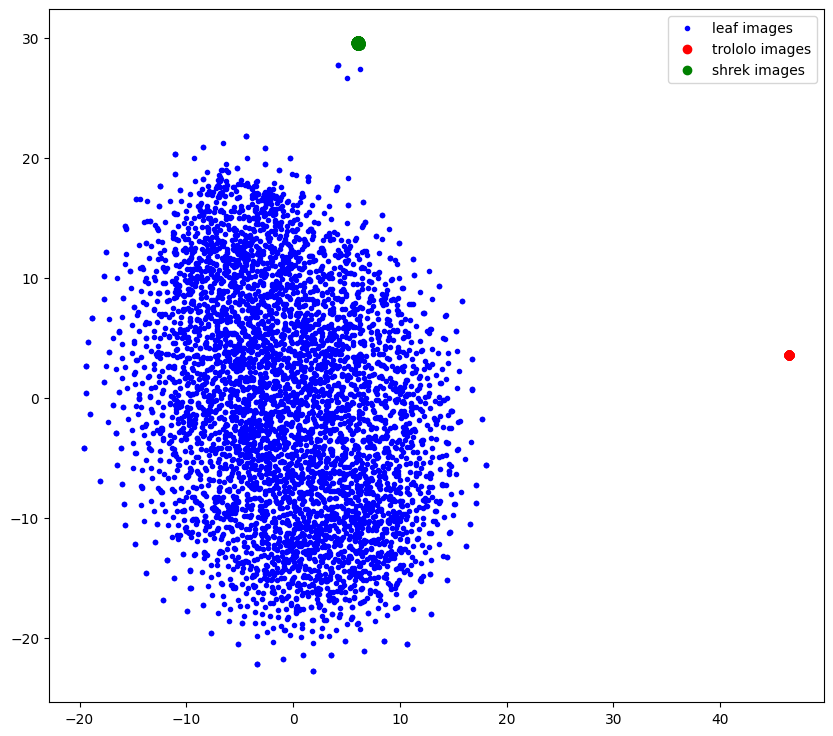

<Figure size 640x480 with 0 Axes>

In [ ]:
tr = 2596
sh = 5171

trolo = np.all(images == images[tr], axis=(1, 2, 3))
shrek = np.all(images == images[sh], axis=(1, 2, 3))
remove = (shrek | trolo)

plt.figure(figsize=(10,9))
#plt.title('Scatterplot of scores of the images ')
plt.plot(scores_tsne[~remove,0],scores_tsne[~remove,1], 'b.', scores_tsne[trolo,0],scores_tsne[trolo,1],'ro', scores_tsne[shrek,0],scores_tsne[shrek,1],'go')
plt.legend(['leaf images','trololo images','shrek images'])
plt.show()
plt.savefig('tsne-outliers.png')

## Data cleaning

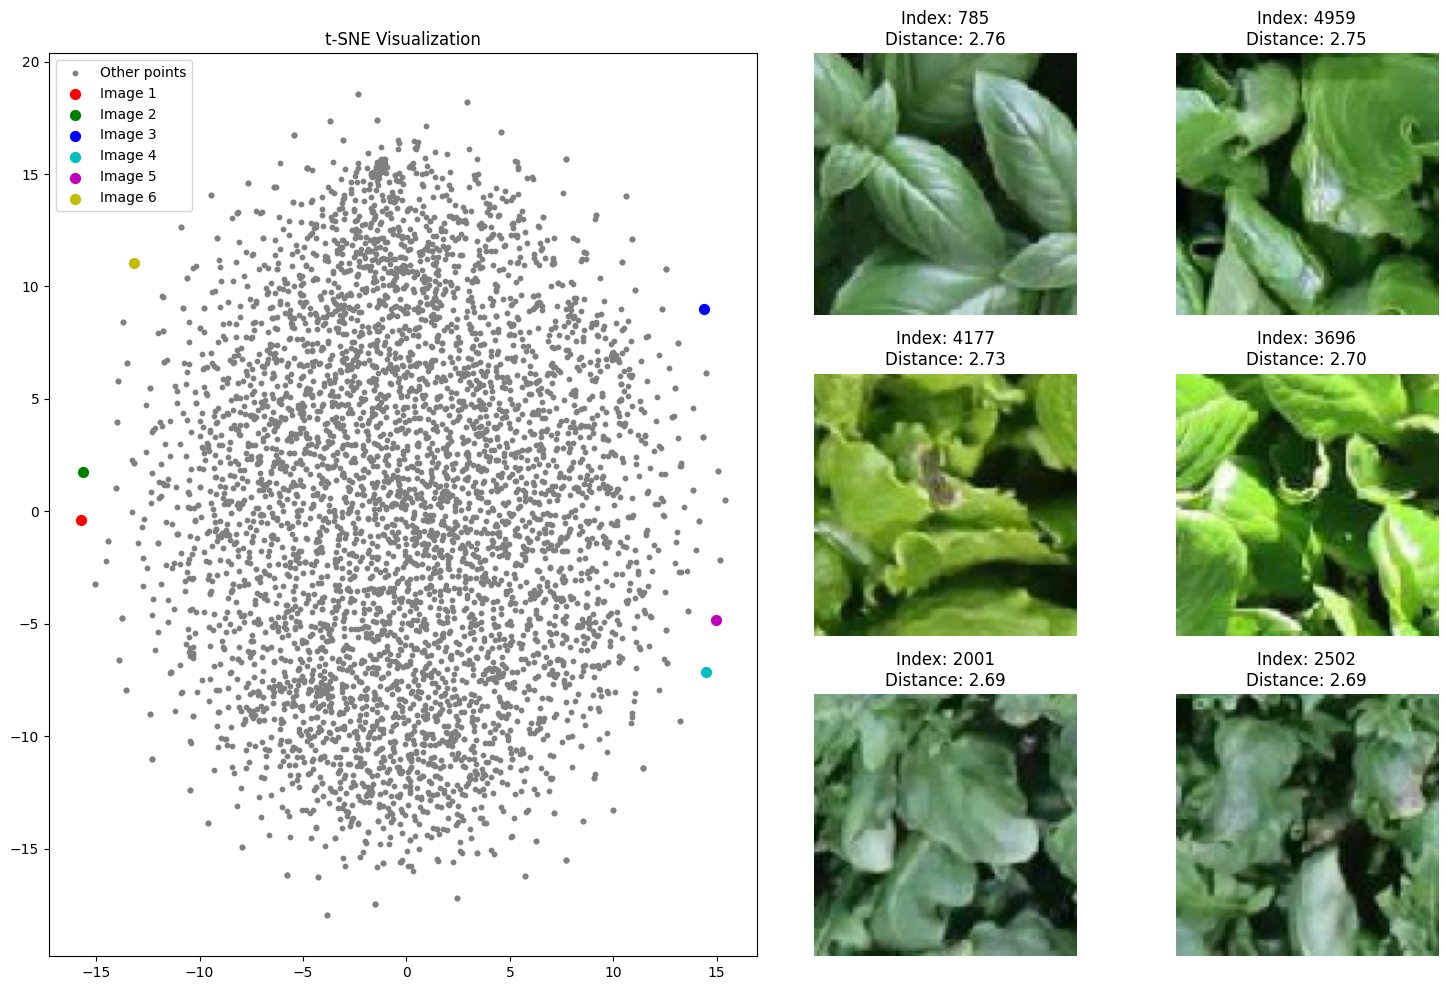

In [ ]:
# Removing the Shrek and TROLOLOLO images
images = images[~remove]
labels = labels[~remove]

images_flat = images_flat[~remove]

#Runing T-SNE again to see if there is anything else to see once the initial Shrek and TROLOLOLO images are gone
tsne_outlier_detection(images_flat)

In [ ]:
# Removed doubles
unique_images, idx_unique = np.unique(images, return_index= True, axis=0)

labels = labels[idx_unique]
images = images[idx_unique]
label , count_label = np.unique(labels, return_counts = True)

print(label)
print(count_label)

['healthy' 'unhealthy']
[3060 1790]


Class imbalance -> generated augmented images of class unhealthy to gap the difference.

## Balance dataset

In [ ]:
# Applying rotations of 90 degrees


# Create a mapping from label string to values
map = {'healthy':0 , 'unhealthy':1}

# Map labels from string to the corresponding encoding
int_labels = np.array(np.where(labels=='unhealthy',1,0))

label , count_label = np.unique(labels, return_counts = True)
gap = count_label[0] - count_label[1]
print('Difference is:',gap)
index = np.where(int_labels==1)[0]
idx = np.random.choice(index,size=gap)

# Layer for Rotation of 90 degrees
data_augmentation = tf.keras.Sequential([
    tfkl.RandomRotation(factor = (0.25,0.25)), # Rotate by 90 degrees
])

new_img = []
for i in idx:
  img_aug = data_augmentation(images[i])
  new_img.append(img_aug)

new_img = np.array(new_img, ndmin = 4)
images = np.vstack([images,new_img])
ones = np.ones(shape=(gap,))
int_labels = np.concatenate([int_labels,ones])
order = np.arange(images.shape[0])
np.random.shuffle(order)
images = images[order]
int_labels = int_labels[order]

Difference is: 1270


### Create preprocessed dataset

In [ ]:
np.savez_compressed('/content/drive/MyDrive/ANNDL: Challenge 1/data_preprocessed.npz', images=images, labels=int_labels)